In [1]:
import re
import wikipedia
import numpy as np
import pandas as pd
import swifter
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

def find_title_on_wikipedia(title, year, show_prints=False):
    search_results = wikipedia.search(title, results=20)
    if show_prints is True:
        print(f'Initial search results: {search_results}')

    search_results_exact = [s for s in search_results if title in s] # results that have the exact title as part of them
    if show_prints is True:
        print(f'Results that have the exact title as part of them: {search_results}')
    
    if len(search_results_exact) != 0: # if the title is part of at least one result

        # if film exists in title but not together with series or score (an example was Resident Evil 2002)
        search_results_film = [s for s in search_results_exact if 'film' in s and 'score' not in s and 'series' not in s]
        if show_prints is True:
            print(f'Results containing "film": {search_results_film}')

        # Go on by additionaly searching for the year in the title
        if len(search_results_film) == 0: # if there is no results with 'film' in the title
            search_results_year = [s for s in search_results_exact if str(year) in s]
            if show_prints is True:
                print(f'Results containing year: {search_results_year}')  
            if len(search_results_year) == 0: # if there is no results with year in the title
                search_results_final = search_results_exact
            else:
                search_results_final = search_results_year
        else:
            search_results_year = [s for s in search_results_film if str(year) in s]
            if show_prints is True:
                print(f'Results containing year: {search_results_year}')  
            if len(search_results_year) == 0:
                search_results_final = search_results_film
            else:
                search_results_final = search_results_year  

        # for the possible remains of the search results take the exact match or the first result
        for s in search_results_final:
            if s == title:
                title = s
            else:
                if show_prints is True:
                    print(f'Final results: {search_results_final}')  
                title = search_results_final[0]
    
    else: # take the first result
        title = search_results[0]

    # for the cases where the wrong date is grabbed e.g Lion King 1994 which gave Lion King 2019
    if len(re.findall('\([1-3][0-9]{3} film\)', title)) !=0:
        if int(re.findall('\([1-3][0-9]{3} film\)', title)[0].split(' ')[0].replace('(', '')) != year:
            if show_prints is True:
                print('##########Date corrected!')
            title = search_results[0]
    if show_prints is True:        
        print(title)
    return title

def enrich_data(x, section_names, show_prints=False):
    """
    Add the columns 'Wikipedia Title' and 'Plot' to the dataset
    """
    imdb_title = x['Title']
    year = x['Year']
    title, page, plot, summary = np.nan, np.nan, np.nan, np.nan

    try:
        if show_prints is True:
            print(imdb_title, year)
            print('='*80)
        title = find_title_on_wikipedia(imdb_title, year, show_prints=show_prints)
        search_results = wikipedia.search(title, results=20)

        page = wikipedia.WikipediaPage(title = title)
    except:
        if show_prints is True:
            print(f'Title "{imdb_title}" does not exist on Wikipedia.')
        # page = np.nan

    for section in section_names:
        try:
            plot = page.section(section)
            if plot != None or plot != np.nan:
                if show_prints is True:
                    print(f'Title "{imdb_title}" was found wih the section tag {section}')
                    print(plot)
                break
        except:
            if show_prints is True:
                print(f'Plot for -{imdb_title}- was not found.')
            # plot = np.nan

    # for some movies with general title e.g. "Up" modify the search by adding (year film) next to title
    if plot is None or plot != np.nan:
        imdb_title = f'{imdb_title} ({year} film)'
        if show_prints is True:
            print(f'**********Retrying {imdb_title} {year}') 
        try:          
            title = find_title_on_wikipedia(imdb_title, year, show_prints=show_prints)
            if show_prints is True:
                print('='*80)
            search_results = wikipedia.search(title, results=20)

            page = wikipedia.WikipediaPage(title = title)
        except:
            if show_prints is True:
                print(f'Title "{imdb_title}" does not exist on Wikipedia.')
            # page = np.nan

        for section in section_names:
            try:
                plot = page.section(section)
                if plot != None or plot != np.nan:
                    if show_prints is True:
                        print(f'Title "{imdb_title}" was found wih the section tag {section}')
                        print(plot)
                    break
            except:
                if show_prints is True:
                    print(f'Plot for -{imdb_title}- was not found.')
                # plot = np.nan    
    if show_prints is True:
        print()
        
    try:
        summary = page.summary
    except:
        if show_prints is True:
            print(f'Summary for -{imdb_title}- was not found.')        
    
    x['Wikipedia Title'] = title
    x['Plot'] = plot
    x['Summary'] = summary
    return x

## Load my IMDb ratings and do some filtering

In [2]:
ratings = pd.read_csv('ratings.csv', encoding='ansi')

In [3]:
ratings

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt1001508,6,2013-08-12,He's Just Not That Into You,https://www.imdb.com/title/tt1001508/,movie,6.4,129.0,2009,"Comedy, Drama, Romance",162920,2009-01-24,Ken Kwapis
1,tt10048342,9,2020-11-04,The Queen's Gambit,https://www.imdb.com/title/tt10048342/,tvMiniSeries,8.6,395.0,2020,"Drama, Sport",279231,2020-10-23,NaN
2,tt0100502,4,2016-09-24,RoboCop 2,https://www.imdb.com/title/tt0100502/,movie,5.8,117.0,1990,"Action, Crime, Sci-Fi, Thriller",81626,1990-06-22,Irvin Kershner
3,tt0100802,8,2012-09-05,Total Recall,https://www.imdb.com/title/tt0100802/,movie,7.5,113.0,1990,"Action, Sci-Fi, Thriller",304273,1990-05-31,Paul Verhoeven
4,tt1010048,10,2013-05-06,Slumdog Millionaire,https://www.imdb.com/title/tt1010048/,movie,8.0,120.0,2008,"Drama, Romance",802553,2008-08-30,"Loveleen Tandan, Danny Boyle"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,tt0099077,6,2020-09-27,Awakenings,https://www.imdb.com/title/tt0099077/,movie,7.8,121.0,1990,"Biography, Drama",126821,1990-12-12,Penny Marshall
1174,tt0993846,6,2020-12-13,The Wolf of Wall Street,https://www.imdb.com/title/tt0993846/,movie,8.2,180.0,2013,"Biography, Crime, Drama",1203392,2013-12-09,Martin Scorsese
1175,tt0997152,6,2016-02-24,The Experiment,https://www.imdb.com/title/tt0997152/,movie,6.4,96.0,2010,"Drama, Thriller",52480,2010-07-15,Paul T. Scheuring
1176,tt0099785,8,2013-05-07,Home Alone,https://www.imdb.com/title/tt0099785/,movie,7.6,103.0,1990,"Comedy, Family",491850,1990-11-10,Chris Columbus


In [4]:
ratings['Title Type'].value_counts()

movie           986
tvSeries        134
video            32
tvMiniSeries     19
tvEpisode         3
short             3
tvMovie           1
Name: Title Type, dtype: int64

### Keep only movies

In [5]:
ratings = ratings.loc[ratings['Title Type']=='movie']
ratings

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt1001508,6,2013-08-12,He's Just Not That Into You,https://www.imdb.com/title/tt1001508/,movie,6.4,129.0,2009,"Comedy, Drama, Romance",162920,2009-01-24,Ken Kwapis
2,tt0100502,4,2016-09-24,RoboCop 2,https://www.imdb.com/title/tt0100502/,movie,5.8,117.0,1990,"Action, Crime, Sci-Fi, Thriller",81626,1990-06-22,Irvin Kershner
3,tt0100802,8,2012-09-05,Total Recall,https://www.imdb.com/title/tt0100802/,movie,7.5,113.0,1990,"Action, Sci-Fi, Thriller",304273,1990-05-31,Paul Verhoeven
4,tt1010048,10,2013-05-06,Slumdog Millionaire,https://www.imdb.com/title/tt1010048/,movie,8.0,120.0,2008,"Drama, Romance",802553,2008-08-30,"Loveleen Tandan, Danny Boyle"
5,tt1013743,7,2013-07-15,Knight and Day,https://www.imdb.com/title/tt1013743/,movie,6.3,109.0,2010,"Action, Adventure, Comedy",181236,2010-06-16,James Mangold
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,tt0099077,6,2020-09-27,Awakenings,https://www.imdb.com/title/tt0099077/,movie,7.8,121.0,1990,"Biography, Drama",126821,1990-12-12,Penny Marshall
1174,tt0993846,6,2020-12-13,The Wolf of Wall Street,https://www.imdb.com/title/tt0993846/,movie,8.2,180.0,2013,"Biography, Crime, Drama",1203392,2013-12-09,Martin Scorsese
1175,tt0997152,6,2016-02-24,The Experiment,https://www.imdb.com/title/tt0997152/,movie,6.4,96.0,2010,"Drama, Thriller",52480,2010-07-15,Paul T. Scheuring
1176,tt0099785,8,2013-05-07,Home Alone,https://www.imdb.com/title/tt0099785/,movie,7.6,103.0,1990,"Comedy, Family",491850,1990-11-10,Chris Columbus


In [6]:
# check for nans
ratings.isnull().sum()

Const             0
Your Rating       0
Date Rated        0
Title             0
URL               0
Title Type        0
IMDb Rating       0
Runtime (mins)    0
Year              0
Genres            0
Num Votes         0
Release Date      0
Directors         0
dtype: int64

## Getting data from Wikipedia

In [7]:
# create a list of possible Wikipedia sections for the movie plot
section_names = ['Plot','Synopsis','Plot synopsis','Plot summary', 'Story','Plotline','The Beginning','Summary', 'Content','Premise']
# expand the list by adding "Edit" at the end of each name, because some Wikipedia pages have it (Wikipedia user error)
section_names.extend([i + 'Edit' for i in section_names])

ratings = ratings.progress_apply(lambda x: enrich_data(x, section_names, show_prints=False), axis=1)

c:\users\jim\appdata\local\programs\python\python38\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\users\jim\appdata\local\programs\python\python38\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [8]:
ratings.isnull().sum()

Const               0
Your Rating         0
Date Rated          0
Title               0
URL                 0
Title Type          0
IMDb Rating         0
Runtime (mins)      0
Year                0
Genres              0
Num Votes           0
Release Date        0
Directors           0
Wikipedia Title     4
Plot               32
Summary             4
dtype: int64

In [9]:
# Remove nans and empty Plots
ratings = ratings.dropna()
ratings = ratings.loc[ratings['Plot']!='']

In [10]:
ratings

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,Wikipedia Title,Plot,Summary
2,tt0100502,4,2016-09-24,RoboCop 2,https://www.imdb.com/title/tt0100502/,movie,5.8,117.0,1990,"Action, Crime, Sci-Fi, Thriller",81626,1990-06-22,Irvin Kershner,RoboCop 2,"In a near dystopian future, Detroit is on the ...",RoboCop 2 is a 1990 American science fiction a...
3,tt0100802,8,2012-09-05,Total Recall,https://www.imdb.com/title/tt0100802/,movie,7.5,113.0,1990,"Action, Sci-Fi, Thriller",304273,1990-05-31,Paul Verhoeven,Total Recall (1990 film),"In 2084, construction worker Douglas Quaid is ...",Total Recall is a 1990 science fiction action ...
4,tt1010048,10,2013-05-06,Slumdog Millionaire,https://www.imdb.com/title/tt1010048/,movie,8.0,120.0,2008,"Drama, Romance",802553,2008-08-30,"Loveleen Tandan, Danny Boyle",Slumdog Millionaire,"Eighteen-year-old Jamal Malik, an Indian Musli...",Slumdog Millionaire is a 2008 India based Brit...
5,tt1013743,7,2013-07-15,Knight and Day,https://www.imdb.com/title/tt1013743/,movie,6.3,109.0,2010,"Action, Adventure, Comedy",181236,2010-06-16,James Mangold,Knight and Day,Returning home to Boston from buying car parts...,Knight and Day is a 2010 American action comed...
6,tt1013752,8,2015-04-16,Fast & Furious,https://www.imdb.com/title/tt1013752/,movie,6.6,107.0,2009,"Action, Thriller",264363,2009-03-12,Justin Lin,Fast & Furious (2009 film),"Five years after escaping from the U.S., Domin...",Fast & Furious (alternatively known as Fast & ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,tt0099077,6,2020-09-27,Awakenings,https://www.imdb.com/title/tt0099077/,movie,7.8,121.0,1990,"Biography, Drama",126821,1990-12-12,Penny Marshall,Awakenings,"In 1969, Dr. Malcolm Sayer (Robin Williams) is...",Awakenings is a 1990 American drama film based...
1174,tt0993846,6,2020-12-13,The Wolf of Wall Street,https://www.imdb.com/title/tt0993846/,movie,8.2,180.0,2013,"Biography, Crime, Drama",1203392,2013-12-09,Martin Scorsese,The Wolf of Wall Street (2013 film),"In 1987, Jordan Belfort lands a job as a Wall ...",The Wolf of Wall Street is a 2013 American epi...
1175,tt0997152,6,2016-02-24,The Experiment,https://www.imdb.com/title/tt0997152/,movie,6.4,96.0,2010,"Drama, Thriller",52480,2010-07-15,Paul T. Scheuring,The Experiment (2010 film),Volunteers arrive for a psychological study le...,The Experiment is a 2010 American drama thrill...
1176,tt0099785,8,2013-05-07,Home Alone,https://www.imdb.com/title/tt0099785/,movie,7.6,103.0,1990,"Comedy, Family",491850,1990-11-10,Chris Columbus,Home Alone,The McCallister family is preparing to spend C...,Home Alone is a 1990 American comedy film writ...


In [11]:
ratings['Plot_Summary'] = ratings['Plot'] + ratings['Summary']
ratings.to_csv('ratings_enriched_with_wikipedia.csv', index=False)

## Topic Modelling

In [12]:
# Import packages and define functions

import collections
from operator import itemgetter
from scipy import stats
# spacy for lemmatization
import spacy

# Import the wordcloud library
from wordcloud import WordCloud

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# NLTK Stop words
import nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def remove_unicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def remove_new_line_characters(text):
    return re.sub('\s+', ' ', text)

def remove_quotes(text):
    text = re.sub("\'", "", text)
    text = re.sub('\"', '', text)
    return text

def lowercase(text):
    return text.lower()

def remove_single_char_words(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def remove_verbs(text):
    final_text = ''
    allowedWordTypes = ["J","R","N"]
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    for w in tagged:
        if w[1][0] in allowedWordTypes:
            final_text += f' {w[0]}'
    return final_text

def text_preprocess(text):
    text = remove_unicode(text)
    text = remove_new_line_characters(text)
    text = remove_quotes(text)
    text = lowercase(text)
    text = remove_single_char_words(text)
    text = remove_verbs(text)
    return text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization_x(sent, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    doc = nlp(" ".join(sent)) 
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

def join_list(the_list):
    str1 = " " 
    return str1.join(the_list)

def allocate_topics(i):
    return lda_model[corpus[i]][0]

def get_max_probability_topic(x, num_topics):
    return  max(x, key=itemgetter(1))[0]

def build_LDA_model(ratings, source, num_topics):
    # Create the Dictionary and Corpus needed for Topic Modeling

    # Create Dictionary
    #id2word = corpora.Dictionary(data_lemmatized)
    id2word = corpora.Dictionary(ratings[f'{source}_lemmatized'].tolist())

    # Create Corpus
    texts = ratings[f'{source}_lemmatized'].tolist()

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    del texts

    # Build LDA model
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=7,
                                               eval_every=10,
                                               chunksize=100,
                                               passes=10,
                                               per_word_topics=True,
                                               workers=8)   
    return lda_model, corpus, id2word

def compute_metrics_per_topics(ratings, source):
    # Calculate the frequency of words for this topic and for all corpora

    # Computed once for all corpus
    corpora_word_counts = [e.split(' ') for e in ratings[f'{source}_preprocessed'].tolist()]
    corpora_word_counts = [item for sublist in corpora_word_counts for item in sublist]
    corpora_word_counts = collections.Counter(corpora_word_counts)
    corpora_word_counts_df = pd.DataFrame.from_dict(corpora_word_counts, orient='index')

    metrics = pd.DataFrame()
    for topic_n in ratings[f'{source}_topic'].unique():
        topic_word_counts = [e.split(' ') for e in ratings.loc[ratings[f'{source}_topic']==topic_n][f'{source}_preprocessed'].tolist()]
        topic_word_counts = [item for sublist in topic_word_counts for item in sublist]
        topic_word_counts=collections.Counter(topic_word_counts)
        topic_word_counts_df = pd.DataFrame.from_dict(topic_word_counts, orient='index')

        word_counts_df = corpora_word_counts_df.merge(topic_word_counts_df, left_index=True, right_index=True, how='left').\
        rename({'0_x': 'corpora','0_y': f'{source}_topic'}, axis=1)
        word_counts_df = word_counts_df.fillna(0)

        metrics = metrics.append({'Topic': topic_n,
                                  'Probability': len(topic_word_counts)/len(corpora_word_counts_df),
                                  'Entropy': stats.entropy(pk=word_counts_df[f'{source}_topic'].values),
                                  'KL': stats.entropy(pk=word_counts_df[f'{source}_topic'].values, qk=word_counts_df['corpora'].values)
                   }, ignore_index=True) 

    return metrics.sort_values(by='Probability')    

def create_topic_specific_wordcloud(ratings, source, topic):
    # Create a WordCloud object for specific topic
    temp = ratings.loc[ratings[f'{source}_topic']==0][f'{source}_preprocessed'].to_list()
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue',
                         width=1800, height=900)
    # Join the different processed titles together.
    long_string = ','.join(temp)
    # Generate a word cloud
    wordcloud.generate(long_string)
    # Visualize the word cloud
    return wordcloud.to_image()

c:\users\jim\appdata\local\programs\python\python38\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


### Pre-processing

In [13]:
# Do the process separately for Plot and Summary columns
source = 'Plot_Summary'
data = ratings.copy()
print(f'---Doing pre-processing for {source}..')
print('Initial pre-processing..')
data[source] = data[source].swifter.apply(lambda x: text_preprocess(x))
data = data[source].to_list()
data_words = list(sent_to_words(data))

# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100, progress_per=200) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

# Remove Stop Words
print('Removing stopwords..')
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
print('Creating bigrams..')
ratings[f'{source}_words_bigrams'] = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print('Lemmatizing words..')
ratings[f'{source}_lemmatized'] = ratings[f'{source}_words_bigrams'].swifter.apply(lambda x: lemmatization_x(x))
ratings = ratings.drop(columns=[f'{source}_words_bigrams'])

ratings[f'{source}_preprocessed'] = ratings[f'{source}_lemmatized'].apply(lambda x: join_list(x))

del bigram, bigram_mod, data_words, data, nlp

---Doing pre-processing for Plot_Summary..
Initial pre-processing..


2021-03-19 20:01:37,712 : INFO : collecting all words and their counts
2021-03-19 20:01:37,713 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-03-19 20:01:37,843 : INFO : PROGRESS: at sentence #200, processed 78606 words and 81305 word types
2021-03-19 20:01:37,975 : INFO : PROGRESS: at sentence #400, processed 154213 words and 148581 word types
2021-03-19 20:01:38,115 : INFO : PROGRESS: at sentence #600, processed 229341 words and 210926 word types
2021-03-19 20:01:38,253 : INFO : PROGRESS: at sentence #800, processed 307571 words and 273513 word types
2021-03-19 20:01:38,359 : INFO : collected 319208 word types from a corpus of 365144 words (unigram + bigrams) and 950 sentences
2021-03-19 20:01:38,360 : INFO : using 319208 counts as vocab in Phrases<0 vocab, min_count=5, threshold=100, max_vocab_size=40000000>
2021-03-19 20:01:38,361 : INFO : source_vocab length 319208
2021-03-19 20:01:41,621 : INFO : Phraser built with 1115 phrasegrams


Removing stopwords..
Creating bigrams..
Lemmatizing words..


## Most common words

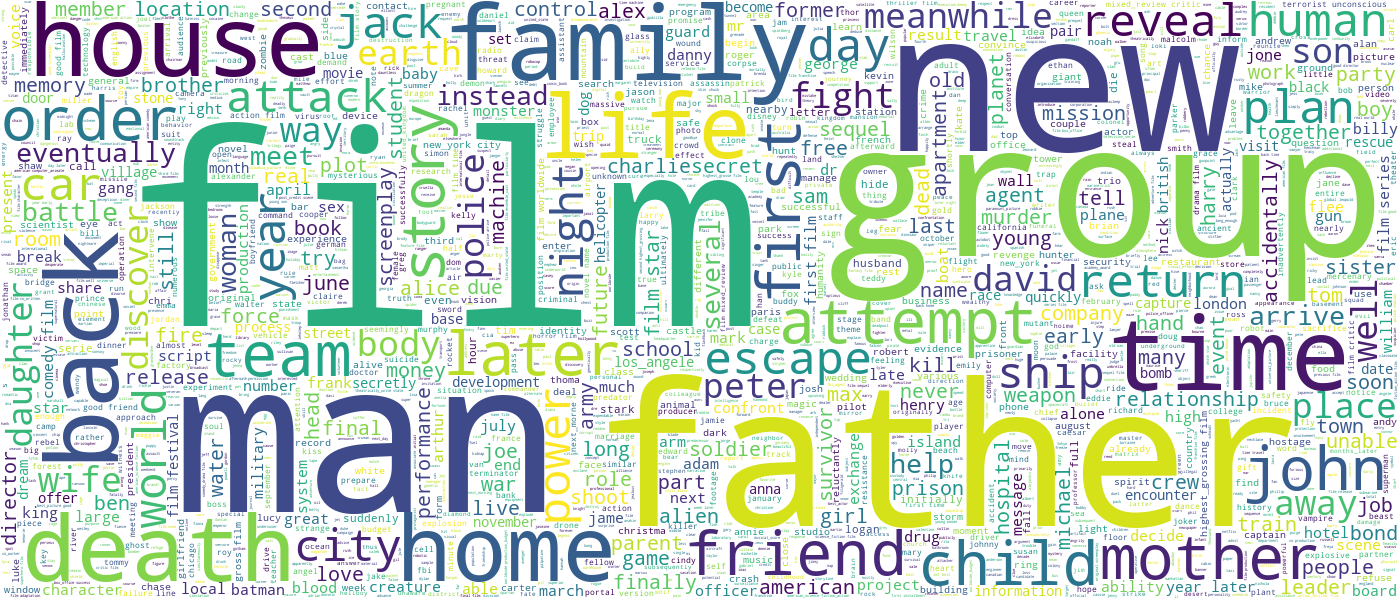

In [14]:
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=2000, contour_width=3, contour_color='steelblue',
                     width=1400, height=600)
# Join the different processed titles together.
long_string = ','.join(ratings[f'{source}_preprocessed'].to_list())
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Build LDA Model

In [15]:
num_topics = 6
lda_model, corpus, id2word = build_LDA_model(ratings, source=source, num_topics=num_topics)
# We can save the model by:
# lda_model.save('lda_model')
# with open('id2word.pkl', 'wb') as f:
#     pickle.dump(id2word, f)
# with open('corpus.pkl', 'wb') as f:
#     pickle.dump(corpus, f)

2021-03-19 20:02:30,216 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-03-19 20:02:30,556 : INFO : built Dictionary(25935 unique tokens: ['ability', 'accomplice', 'accountability', 'activation', 'actor']...) from 950 documents (total 321170 corpus positions)
2021-03-19 20:02:30,738 : INFO : using symmetric alpha at 0.16666666666666666
2021-03-19 20:02:30,739 : INFO : using symmetric eta at 0.16666666666666666
2021-03-19 20:02:30,743 : INFO : using serial LDA version on this node
2021-03-19 20:02:30,761 : INFO : running online LDA training, 6 topics, 10 passes over the supplied corpus of 950 documents, updating every 800 documents, evaluating every ~950 documents, iterating 50x with a convergence threshold of 0.001000
2021-03-19 20:02:30,763 : INFO : training LDA model using 8 processes
2021-03-19 20:02:30,847 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #100/950, outstanding queue size 1
2021-03-19 20:02:30,877 : INFO : PROGRESS: pass 0, dispatc

In [16]:
lda_model.print_topics()

2021-03-19 20:02:37,901 : INFO : topic #0 (0.167): 0.018*"film" + 0.004*"time" + 0.004*"john" + 0.004*"back" + 0.004*"family" + 0.004*"year" + 0.003*"home" + 0.003*"house" + 0.003*"also" + 0.003*"group"
2021-03-19 20:02:37,902 : INFO : topic #1 (0.167): 0.021*"film" + 0.004*"time" + 0.004*"jack" + 0.004*"man" + 0.004*"first" + 0.003*"death" + 0.003*"team" + 0.003*"back" + 0.003*"luke" + 0.003*"also"
2021-03-19 20:02:37,905 : INFO : topic #2 (0.167): 0.019*"film" + 0.004*"police" + 0.004*"man" + 0.004*"father" + 0.003*"time" + 0.003*"also" + 0.003*"family" + 0.003*"car" + 0.003*"later" + 0.003*"home"
2021-03-19 20:02:37,907 : INFO : topic #3 (0.167): 0.018*"film" + 0.005*"mother" + 0.004*"daughter" + 0.004*"woman" + 0.003*"also" + 0.003*"arthur" + 0.003*"grey" + 0.003*"father" + 0.003*"death" + 0.003*"time"
2021-03-19 20:02:37,908 : INFO : topic #4 (0.167): 0.017*"film" + 0.004*"alex" + 0.003*"rambo" + 0.003*"house" + 0.003*"later" + 0.003*"first" + 0.003*"vlad" + 0.003*"time" + 0.003*"

[(0,
  '0.018*"film" + 0.004*"time" + 0.004*"john" + 0.004*"back" + 0.004*"family" + 0.004*"year" + 0.003*"home" + 0.003*"house" + 0.003*"also" + 0.003*"group"'),
 (1,
  '0.021*"film" + 0.004*"time" + 0.004*"jack" + 0.004*"man" + 0.004*"first" + 0.003*"death" + 0.003*"team" + 0.003*"back" + 0.003*"luke" + 0.003*"also"'),
 (2,
  '0.019*"film" + 0.004*"police" + 0.004*"man" + 0.004*"father" + 0.003*"time" + 0.003*"also" + 0.003*"family" + 0.003*"car" + 0.003*"later" + 0.003*"home"'),
 (3,
  '0.018*"film" + 0.005*"mother" + 0.004*"daughter" + 0.004*"woman" + 0.003*"also" + 0.003*"arthur" + 0.003*"grey" + 0.003*"father" + 0.003*"death" + 0.003*"time"'),
 (4,
  '0.017*"film" + 0.004*"alex" + 0.003*"rambo" + 0.003*"house" + 0.003*"later" + 0.003*"first" + 0.003*"vlad" + 0.003*"time" + 0.003*"richard" + 0.003*"man"'),
 (5,
  '0.018*"film" + 0.004*"human" + 0.004*"alien" + 0.004*"john" + 0.003*"first" + 0.003*"later" + 0.003*"ship" + 0.003*"family" + 0.003*"new" + 0.003*"man"')]

## Metrics of Evaluation

In [17]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

2021-03-19 20:02:39,662 : INFO : -8.845 per-word bound, 459.9 perplexity estimate based on a held-out corpus of 950 documents with 321170 words



Perplexity:  -8.845291534252993


### Topic specific metrics:
**Probability**: The probability of a topic represents how common a topic is across all tweets and is calculated by dividing the number of word tokens assigned to the topic by the sum of the token counts for all topics. Take note of the range of the probabilities. lowest-highest

**Entropy**: Represents the distribution characteristics of a topic across documents. For example, if entropy is high the topic is distributed evenly over documents (tweets), whereas if entropy is low the topic is concentrated on a smaller number of tweets

**Kullback-Leibler divergence**: Corpus distance represents how far a topic is from the overall distribution of words in the corpus. A greater corpus distance means that the topic is more distinct as compared to the overall distribution of words, whereas a smaller distance means that the topic is more similar to the corpus distribution.

### Allocating topics to movies

In [18]:
ratings['i'] = [i for i in range(len(ratings))]
ratings[f'{source}_topic'] = ratings['i'].swifter.apply(lambda x: allocate_topics(x))
ratings[f'{source}_topic'] = ratings[f'{source}_topic'].apply(lambda x: get_max_probability_topic(x, num_topics))

In [19]:
compute_metrics_per_topics(ratings, source=source)

,Entropy,KL,Probability,Topic
5,7.982281,0.688638,0.253403,4.0
3,8.191361,0.483660,0.354386,3.0
1,8.193158,0.449462,0.366647,2.0
0,8.206450,0.411710,0.383112,5.0
4,8.240872,0.358858,0.417081,0.0
2,8.324755,0.323332,0.475381,1.0


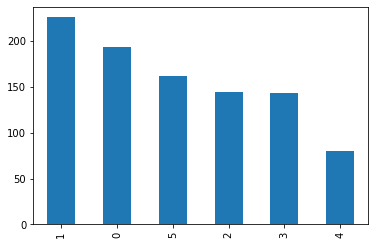

In [20]:
ratings[f'{source}_topic'].value_counts().plot(kind='bar');

In [21]:
# We can create a wordcloud for a specific topic
# create_topic_specific_wordcloud(ratings, source='Plot', topic=0)

## Visualize Topics

In [22]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.019772 -0.029106       1        1  26.342735
0     -0.022005 -0.005734       2        1  19.242996
5     -0.030581 -0.105506       3        1  18.282459
2     -0.043510  0.037961       4        1  14.840201
3     -0.039144  0.093469       5        1  14.050588
4      0.155012  0.008917       6        1   7.241021, topic_info=            Term         Freq        Total Category  logprob  loglift
80          film  6088.000000  6088.000000  Default  30.0000  30.0000
7           alex   159.000000   159.000000  Default  29.0000  29.0000
1476        jack   494.000000   494.000000  Default  28.0000  28.0000
9231        luke   262.000000   262.000000  Default  27.0000  27.0000
2135  terminator   142.000000   142.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1494       night    48.897968   569.714969   Topic6  -6.1646   0.1700
327        order    48.309178   544.464385   Topic6  -6.1767   0.2032
516       mother    48.598621   700.268326   Topic6  -6.1707  -0.0425
1175      friend    48.158936   668.156868   Topic6  -6.1798  -0.0046
1165      family    45.807129   890.143067   Topic6  -6.2299  -0.3415

[481 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
25525      4  0.993003    aang
23489      4  0.960108   adrin
25827      2  0.987051   akari
7          1  0.269140    alex
7          2  0.031295    alex
...      ...       ...     ...
3395       3  0.125070  zombie
3395       4  0.012507  zombie
3395       5  0.137576  zombie
3395       6  0.700389  zombie
25545      4  0.983422    zuko

[1006 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 3, 4, 5])